In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report



import tensorflow as tf
from keras.layers import DepthwiseConv2D,BatchNormalization,ReLU,Conv2D,Dense,AveragePooling2D,Input,Flatten,Dropout
from keras.models import Model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adamax

In [2]:
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 719.8 kB/s eta 0:00:00


In [4]:
import patoolib
patoolib.extract_archive("/content/sample_data/DataSetLeaves.zip",outdir="/content/Dataset")

INFO patool: Extracting /content/sample_data/DataSetLeaves.zip ...
INFO:patool:Extracting /content/sample_data/DataSetLeaves.zip ...
INFO patool: ... creating output directory `/content/Dataset'.
INFO:patool:... creating output directory `/content/Dataset'.
INFO patool: running /usr/bin/7z x -o/content/Dataset -- /content/sample_data/DataSetLeaves.zip
INFO:patool:running /usr/bin/7z x -o/content/Dataset -- /content/sample_data/DataSetLeaves.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/sample_data/DataSetLeaves.zip extracted to `/content/Dataset'.
INFO:patool:... /content/sample_data/DataSetLeaves.zip extracted to `/content/Dataset'.


'/content/Dataset'

In [5]:
data_dir = '/content/Dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [6]:
df

,filepaths,labels
0,/content/Dataset/Powdery Mildew/IMG_20211107_1...,Powdery Mildew
1,/content/Dataset/Powdery Mildew/IMG_20211107_1...,Powdery Mildew
2,/content/Dataset/Powdery Mildew/20211109_12145...,Powdery Mildew
3,/content/Dataset/Powdery Mildew/20211109_12152...,Powdery Mildew
4,/content/Dataset/Powdery Mildew/IMG_20211107_1...,Powdery Mildew
...,...,...
3995,/content/Dataset/Die Back/20211129_161717 (Cus...,Die Back
3996,/content/Dataset/Die Back/20211129_161108 (Cus...,Die Back
3997,/content/Dataset/Die Back/20211129_163806 (Cus...,Die Back
3998,/content/Dataset/Die Back/20211129_164312 (Cus...,Die Back


In [7]:
train_df, dummy_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [8]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended: Use a custom function for test data batch size; otherwise, use the normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

# This function, which will be used in the image data generator for data augmentation,
# takes the image and returns it again.
def scalar(img):
    return img

# Add data augmentation parameters
train_gen = ImageDataGenerator(
    preprocessing_function=scalar,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_gen = ImageDataGenerator(preprocessing_function=scalar)

test_gen = ImageDataGenerator(preprocessing_function=scalar)

# Flow from DataFrame with data augmentation
train_generator = train_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_generator = valid_gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

# Note: we will use custom test_batch_size, and make shuffle= false
test_generator = test_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)


Found 2800 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.


In [9]:
print(train_generator)


**MobileNetV1 Architecture**

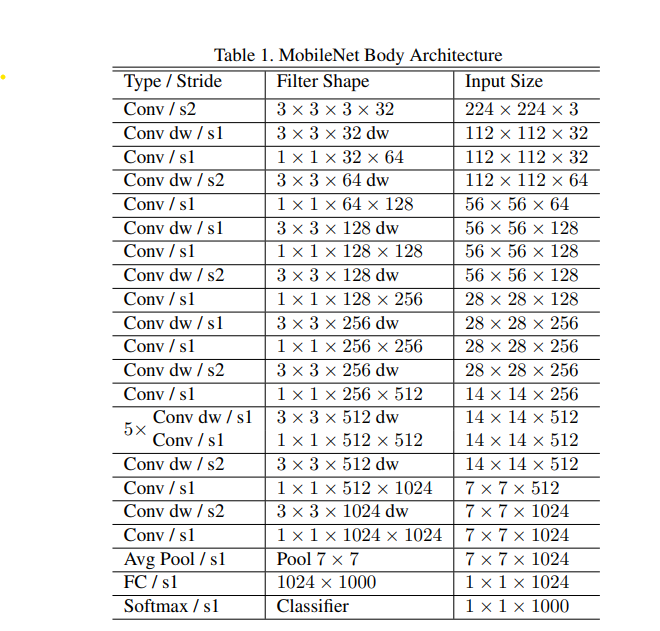

In [10]:
def mobile_block(x,filters,strides):
  #depthwise convolution
  x = DepthwiseConv2D(kernel_size = 3,strides = strides,padding = "same")(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  #pointwise convolution
  x = Conv2D(filters = filters,kernel_size = 1,strides = 1)(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  return x



In [11]:
img_h = 224
img_w = 224
channels = 3

In [12]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_generator.class_indices.keys()))


input = Input(shape =(img_h,img_w,channels))
print(input.shape)
x  = Conv2D(filters = 32,kernel_size = (3,3),strides = (2,2),padding = 'same')(input)
x  = BatchNormalization()(x)
x = ReLU()(x)
print(x.shape)

x = mobile_block(x, filters =64,strides = 1)
print(x.shape)
x = mobile_block(x, filters =128,strides = 2)
print(x.shape)
x = mobile_block(x, filters =128,strides = 1)
print(x.shape)
x = mobile_block(x, filters =256,strides = 2)
x = mobile_block(x, filters =256,strides = 1)
x = mobile_block(x, filters =512,strides = 2)

for  i in range(5):
  x = mobile_block(x, filters =512,strides = 1)

x = mobile_block(x, filters =1024,strides = 2)
x = mobile_block(x, filters =1024,strides = 1)

output = AveragePooling2D(pool_size = (7,7),strides = 1)(x)
output = Flatten()(output)

base_model = Model(inputs = input, outputs = output)


model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(1000, activation= 'relu'),  # Adjust regularization
    Dropout(rate=0.3, seed=123),  # Adjust dropout rate
    Dense(class_count, activation='softmax')
])
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()



(None, 224, 224, 3)
(None, 112, 112, 32)
(None, 112, 112, 64)
(None, 56, 56, 128)
(None, 56, 56, 128)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 1024)              3239808   
                                                                 
 batch_normalization_27 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 1000)              1025000   
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 8)                 8008      
                                                                 
Total params: 427691

In [13]:
batch_size = 32   # set batch size for training
epochs = 30  # number of all epochs in training
history = model.fit(
    x=train_generator,
    epochs=epochs,
    verbose=1,
    validation_data=valid_generator,

    shuffle=True,  # Set to True if you want to shuffle data during training

)


Epoch 1/30
88/88 [==============================] - 65s 481ms/step - loss: 1.4443 - accuracy: 0.5086 - val_loss: 2.3472 - val_accuracy: 0.1117
Epoch 2/30
88/88 [==============================] - 40s 453ms/step - loss: 0.9289 - accuracy: 0.6711 - val_loss: 2.9171 - val_accuracy: 0.1300
Epoch 3/30
88/88 [==============================] - 40s 457ms/step - loss: 0.6876 - accuracy: 0.7571 - val_loss: 3.6708 - val_accuracy: 0.1400
Epoch 4/30
88/88 [==============================] - 40s 459ms/step - loss: 0.5676 - accuracy: 0.8082 - val_loss: 5.1467 - val_accuracy: 0.1167
Epoch 5/30
88/88 [==============================] - 40s 457ms/step - loss: 0.4289 - accuracy: 0.8475 - val_loss: 5.9031 - val_accuracy: 0.1400
Epoch 6/30
88/88 [==============================] - 41s 460ms/step - loss: 0.4189 - accuracy: 0.8561 - val_loss: 8.9995 - val_accuracy: 0.1400
Epoch 7/30
88/88 [==============================] - 41s 462ms/step - loss: 0.3596 - accuracy: 0.8821 - val_loss: 7.8069 - val_accuracy: 0.1400

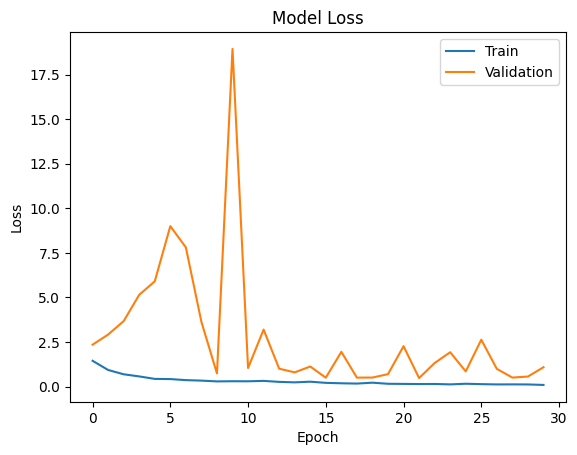

In [14]:

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.legend(loc='upper right')

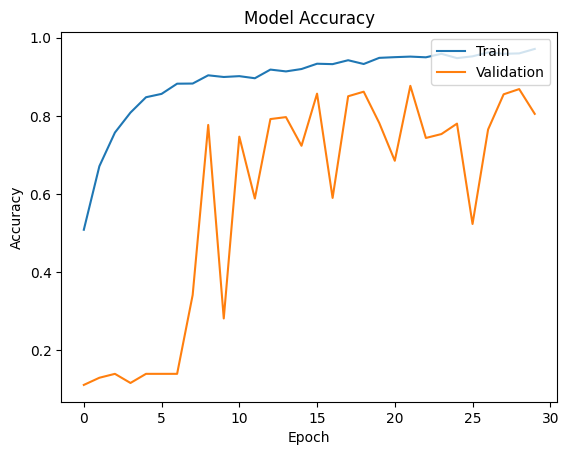

In [15]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Model Accuracy')
plt.legend(loc='upper right')

In [16]:
# Save the trained teacher model
model.save('mobilenet.h5')

# Convert the history dictionary to a DataFrame
history_df = pd.DataFrame(history.history)

# Save the training history to a CSV file
history_df.to_csv('training_history_mobile_net.csv', index=False)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
preds = model.predict_generator(test_generator)
y_pred = np.argmax(preds, axis=1)

<ipython-input-18-aae48f26bcd4>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator)


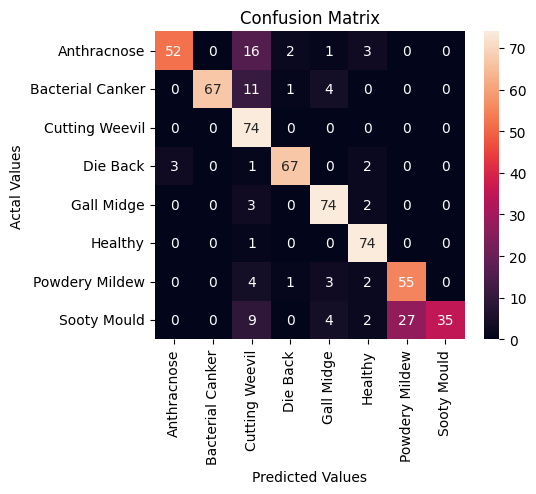

In [20]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_generator.classes, y_pred)
cm_df = pd.DataFrame(cm,
                     index = classes,
                     columns = classes)

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


In [24]:
# import the module
import shutil

# Specify the path of the file you want to copy
file_to_copy = '/content/sample_data/DataSetLeaves.zip'

# Specify the path of the destination directory you want to copy to
destination_directory = '/content/drive/MyDrive/DataSets'

# Use the shutil.copy() method to copy the file to the destination directory
shutil.copy(file_to_copy, destination_directory)

'/content/drive/MyDrive/DataSets/DataSetLeaves.zip'